## Multi-objective optimization with achievement scalarizing functions

Here we are going to a discrete optimization problem with multiple objectives. The experiment involves selecting fragments (A, B, and C) which are linked together to form a dye molecule. The molecules are then tested for emission.

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus import Surface
from olympus.campaigns import ParameterSpace, Campaign
from olympus.objects import ParameterContinuous
from olympus.datasets import Dataset
from atlas.planners.gp.planner import GPPlanner
from atlas.unknown_constraints.benchmark_functions import BraninConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm


The emission signature is characterized using spectroscopy, and we want to optimize multiple propertes:
 - Peak score: which is the integral in a wavelength region in the emission spectra (maximize);
 - Spectral overlap: which is the overlap between absorption and emission bands (minimize);
 - Fluorescence rate: rate of fluorescence (maximize)

In [14]:
BUDGET = 200
NUM_INIT_DESIGN = 10

In [ ]:
dataset = Dataset(kind='dye_lasers')

campaign = Campaign()
campaign.set_param_space(dataset.param_space)

planner = GPPlanner(
    goal='minimize',        # always use minimize if usign Hyparameter scalarizer
    is_moo=True,            # flag the multi-objective optimization
    num_init_design=NUM_INIT_DESIGN,
    scalarizer_kind='Hypervolume',
    value_space=dataset.value_space,
    goals=['max', 'min', 'max'],        # goals here for each individual measurement goal
)
planner.set_param_space(dataset.param_space)


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                                                                                   
                                                 Welcome to ATLAS!                                                 

                                                Made with 💕 in 🇨🇦                                                 
                                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

───────────────────────────── Initial design phase ─────────────────────────────

In [ ]:
iter_ = 0
while len(campaign.observations.get_values()) < BUDGET: 

    print(f'\nITER : {iter_+1}/{BUDGET}\n')

    samples = planner.recommend(campaign.observations)

    for sample in samples:
        measurement = dataset.run(sample, return_paramvector=True, noiseless=True)[0]
        print('SAMPLE : ', sample)
        print('MEASUREMENT : ', measurement)
        
        campaign.add_and_scalarize(sample, measurement, planner.scalarizer)

        iter_ += 1

x0_col = campaign.observations.get_params()[:, 0]
x1_col = campaign.observations.get_params()[:, 1]
x2_col = campaign.observations.get_params()[:, 2]

obj0_col = campaign.observations.get_values()[:, 0]
obj1_col = campaign.observations.get_values()[:, 1]
obj2_col = campaign.observations.get_values()[:, 2]

scalar = campaign.scalarized_values.flatten()


data = pd.DataFrame({
    'frag_a': x0_col,
    'frag_b': x1_col,
    'frag_c': x2_col,
    'peak_score': obj0_col,
    'spectral_overlap': obj1_col,
    'fluo_rate': obj2_col,
    'scalar': scalar
})

Here we plot the results. Remember that we are scalarizing and optimizing the hypervolume, so the properties are not explicitly maximized, rather the combined score is. The traces of the optimization are shown below.

In [17]:
data.head()

,frag_a,frag_b,frag_c,peak_score,spectral_overlap,fluo_rate,scalar
0,OB(O)c1ccnc(F)c1,C[N+]12CC(=O)O[B-]1(c1sccc1Br)OC(=O)C2,Brc1ccc2c(c1)C1(c3ccccc3-c3ccccc31)c1cc(Br)ccc1-2,0.782739,0.103927,0.494931,0.536276
1,OB(O)c1ccnc(-n2c3ccccc3c3ccccc32)c1,C[N+]12CC(=O)O[B-]1(c1sccc1Br)OC(=O)C2,Fc1cc(Br)c(F)cc1Br,0.009806,0.043146,0.003347,0.999962
2,OB(O)c1cc(F)cc(F)c1,C[N+]12CC(=O)O[B-]1(c1cc(I)cc(C(F)(F)F)c1)OC(=...,Brc1ccc2nc3ccc(Br)cc3nc2c1,0.006086,0.003755,0.001295,0.999991
3,CC(C)(C)OC(=O)n1ccc2cc(B3OC(C)(C)C(C)(C)O3)ccc21,C[N+]12CC(=O)O[B-]1(c1c(F)cccc1Br)OC(=O)C2,Brc1ccc(Br)o1,0.102646,0.108302,0.310615,0.962472
4,OB(O)c1ccc(F)c2ccccc12,C[N+]12CC(=O)O[B-]1(c1ccc(Br)cc1)OC(=O)C2,C[Si](C)(c1ccc(Br)cc1)c1ccc(Br)cc1,0.001499,0.279819,1.105198,0.999658


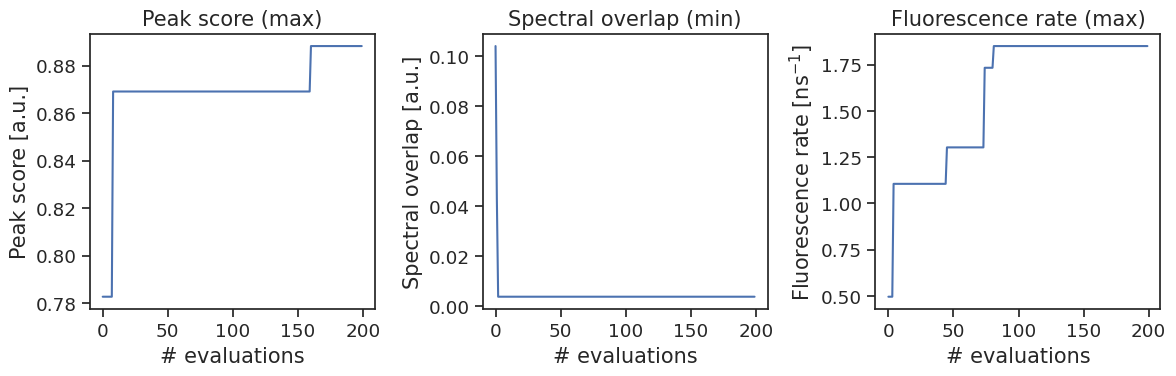

In [18]:
# process the dataset, get the best values
data['best_peak_score'] = data['peak_score'].cummax()
data['best_spectral_overlap'] = data['spectral_overlap'].cummin()
data['best_fluo_rate'] = data['fluo_rate'].cummax()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=data, x=data.index, y='best_peak_score', ax=axes[0])
axes[0].set_xlabel(r'# evaluations', fontsize=15)
axes[0].set_ylabel(r'Peak score [a.u.]', fontsize=15)
axes[0].set_title('Peak score (max)', fontsize=15)

sns.lineplot(data=data, x=data.index, y='best_spectral_overlap', ax=axes[1], legend=False)
axes[1].set_xlabel(r'# evaluations', fontsize=15)
axes[1].set_ylabel(r'Spectral overlap [a.u.]', fontsize=15)
axes[1].set_title('Spectral overlap (min)', fontsize=15)

sns.lineplot(data=data, x=data.index, y='best_fluo_rate', ax=axes[2], legend=False)
axes[2].set_xlabel(r'# evaluations', fontsize=15)
axes[2].set_ylabel(r'Fluorescence rate [ns$^{-1}$]', fontsize=15)
axes[2].set_title('Fluorescence rate (max)', fontsize=15)

fig.tight_layout()